In [1]:
import torch
import torchvision
import sys
import rasterio
from tqdm import tqdm
import matplotlib.pyplot as plt
import higra as hg
import time
import numpy as np
import cv2

In [2]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 1.13.1
Torchvision version: 0.14.1
CUDA is available: False


In [3]:
 _start_time = time.time()
image = cv2.imread('google_chips/output_grid_0_0.tif') # Copy the link of your image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

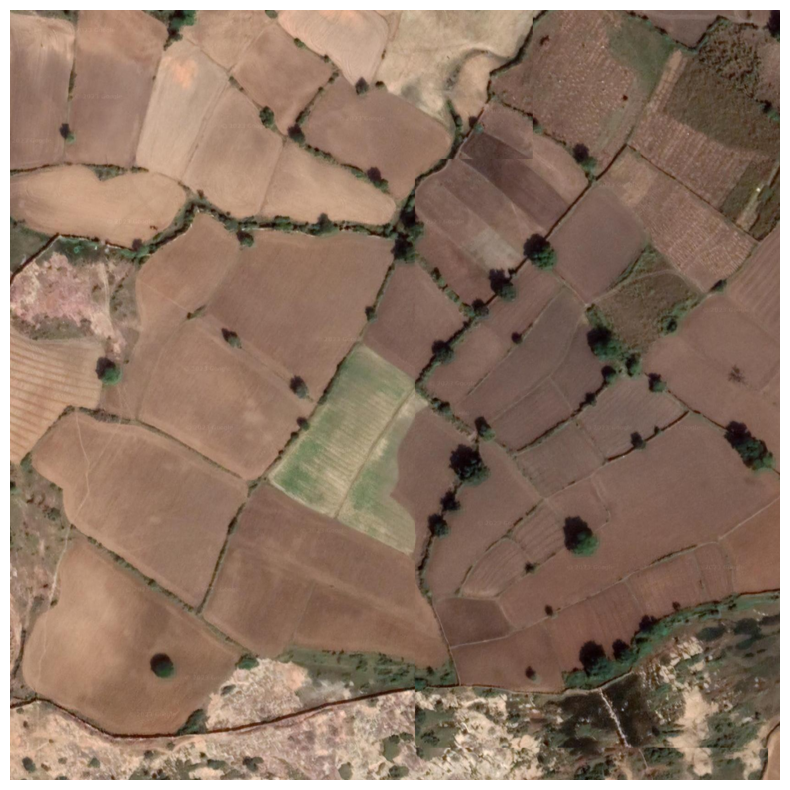

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

Using a SAM model, generates masks for the entire image.
Generates a grid of point prompts over the image, then filters
low quality and duplicate masks. The default settings are chosen
for SAM with a ViT-H backbone.

        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crops_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crops_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:
masks = mask_generator.generate(image)
elapsed_time = time.time() - _start_time
print(elapsed_time/60)

8.14592885573705


In [7]:
print(len(masks))
print(masks[0].keys())

137
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

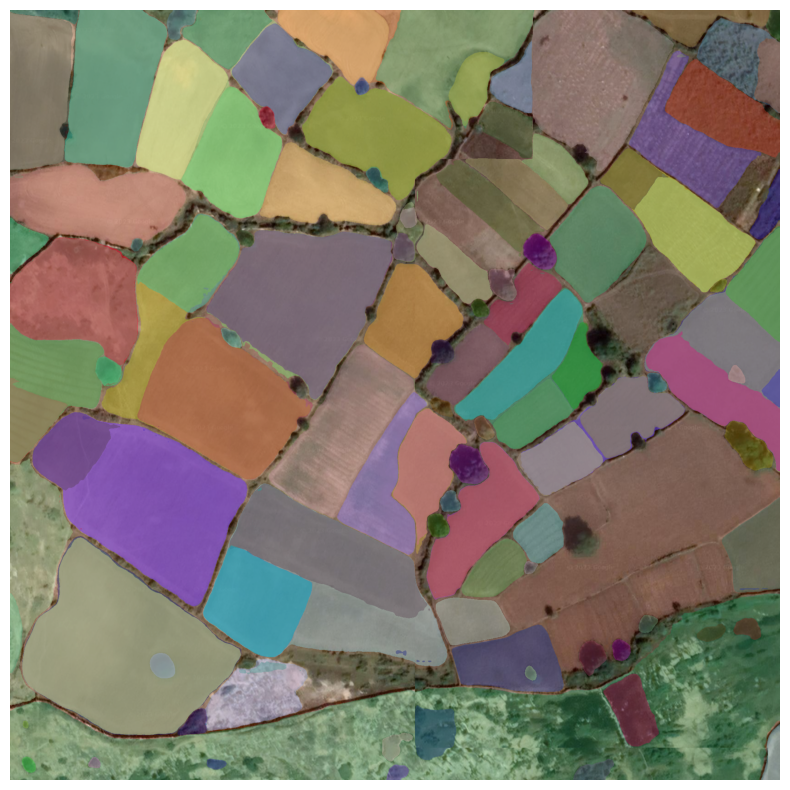

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [10]:
rst = rasterio.open('google_chips/output_grid_0_0.tif')
meta = rst.meta.copy()
    
meta.update(compress='lzw',dtype='float32', nodata=-10000, count=3)

In [11]:
h, w, _ = image.shape

In [12]:
resulting_mask = np.zeros((h, w), dtype=np.uint8)

In [13]:
resulting_borders = np.zeros((h, w), dtype=np.uint8)

In [14]:
erosion_kernel=(3, 3)
erosion_kernel = np.ones(erosion_kernel, np.uint8)

In [15]:
for m in masks:
    mask = (m['segmentation'] > 0).astype(np.uint8)
    resulting_mask += mask

    if erosion_kernel is not None:
        mask_erode = cv2.erode(mask, erosion_kernel, iterations=1)
        mask_erode = (mask_erode > 0).astype(np.uint8)
        edge_mask = mask - mask_erode
        resulting_borders += edge_mask


(-0.5, 1999.5, 1999.5, -0.5)

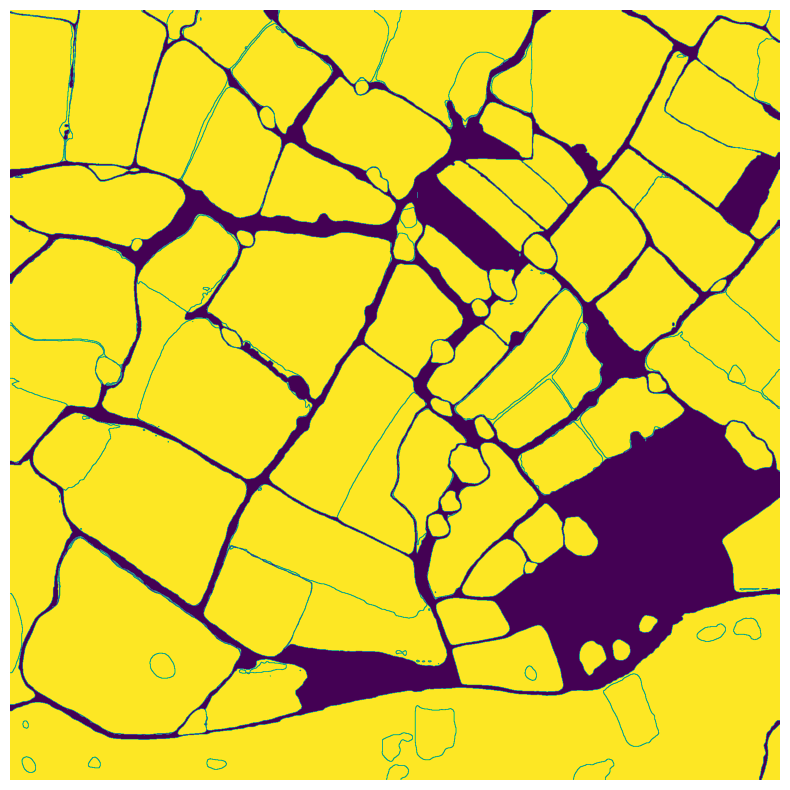

In [16]:
resulting_mask = (resulting_mask > 0).astype(np.float64)
resulting_borders = (resulting_borders > 0).astype(np.float64)
resulting_mask_with_borders = resulting_mask - resulting_borders

r_xtt_mrg = resulting_mask_with_borders.copy()
r_xtt_mrg = (r_xtt_mrg > 0).astype(np.float64)
plt.figure(figsize=(10,10))
plt.imshow(r_xtt_mrg)
# show_anns(masks)
plt.axis('off')

In [17]:
def boundary(my_array, kernel_size=(3, 3)):
    """
   Return the boundary of image objects.
   Parameters
   ----------
   my_array : 2D array
       Binary array with the image object as 1 and the background as 0.

   kernel_size : list (x, y)
       Kernel dimension to thicken the boundaries; (3,3) by default.

   Returns
   -------
   my_dist
       Normalised distance to the boundary of the image object.
   """
    my_canny = cv2.Canny(my_array.astype(np.uint8), 0, 1)
    my_boundary = cv2.dilate(my_canny.astype(np.uint8),
                             cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size),
                             iterations=1)
    my_boundary = my_boundary.astype(np.float32)
    my_boundary /= 255.

    return my_boundary


def distance_transform(my_array):
    """
    Return the normalised distance (distance transform) to the boundary of an image object.
    Parameters
    ----------
    my_array : 2D array
        Binary array with the image object as 1 and the background as 0.

    Returns
    -------
    my_dist
        Normalised distance to the boundary of the image object.
    """
    ndist = cv2.distanceTransform(my_array.astype(np.uint8),
                                  cv2.DIST_L2, 0)
    ndist = np.around(cv2.normalize(ndist, ndist, 0, 1.0, cv2.NORM_MINMAX), 2)
    ndist[my_array == 0] = 0

    return ndist


def ndistance(my_array):
    """
    Return the normalised distance (distance transform) to the boundary of an image object.
    Parameters
    ----------
    my_array : 2D array
        Binary array with the image object as 1 and the background as 0.

    Returns
    -------
    my_dist
        Normalised distance to the boundary of the image object.
    """
    dst_mrg = my_array.copy().astype(float)
    dst_mrg[:, :] = 0
    # loop through all fields to get the normalised distance
    for i in np.unique(my_array)[1::]:
        r_xtt = my_array.copy()
        r_xtt[r_xtt != i] = 0
        # compute distance transform
        r_dst = distance_transform(r_xtt.astype(int))
        # merge with other fields
        # (we keep the maximum distance for every pixel)
        dst_mrg[:, :] = np.maximum(dst_mrg[:, :], r_dst[:, :])

    return dst_mrg

(-0.5, 1999.5, 1999.5, -0.5)

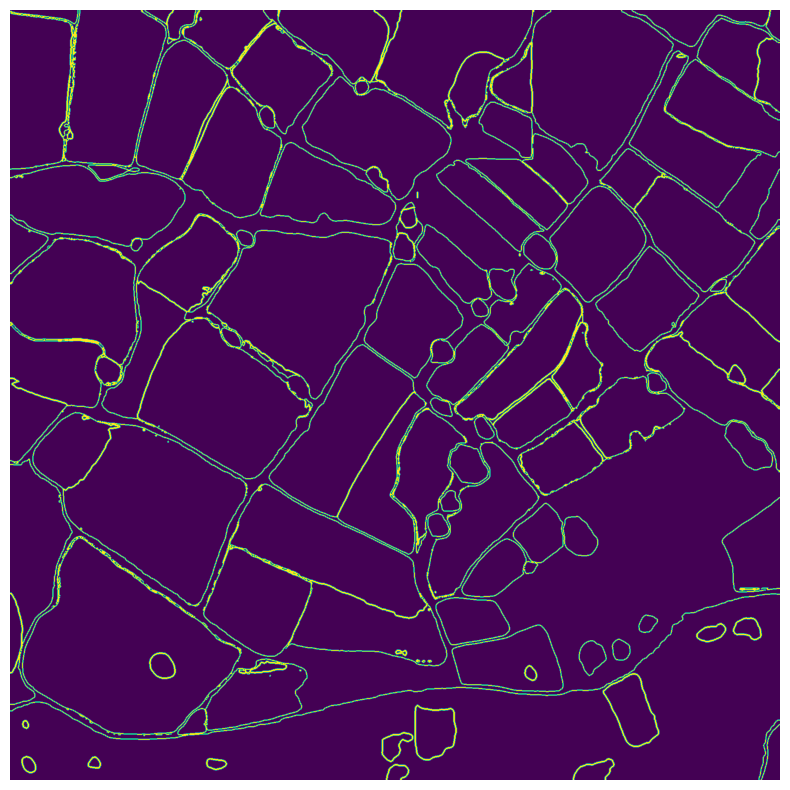

In [18]:
r_bnd_mrg = boundary(resulting_mask_with_borders)
plt.figure(figsize=(10,10))
plt.imshow(r_bnd_mrg)
# show_anns(masks)
plt.axis('off')

(-0.5, 1999.5, 1999.5, -0.5)

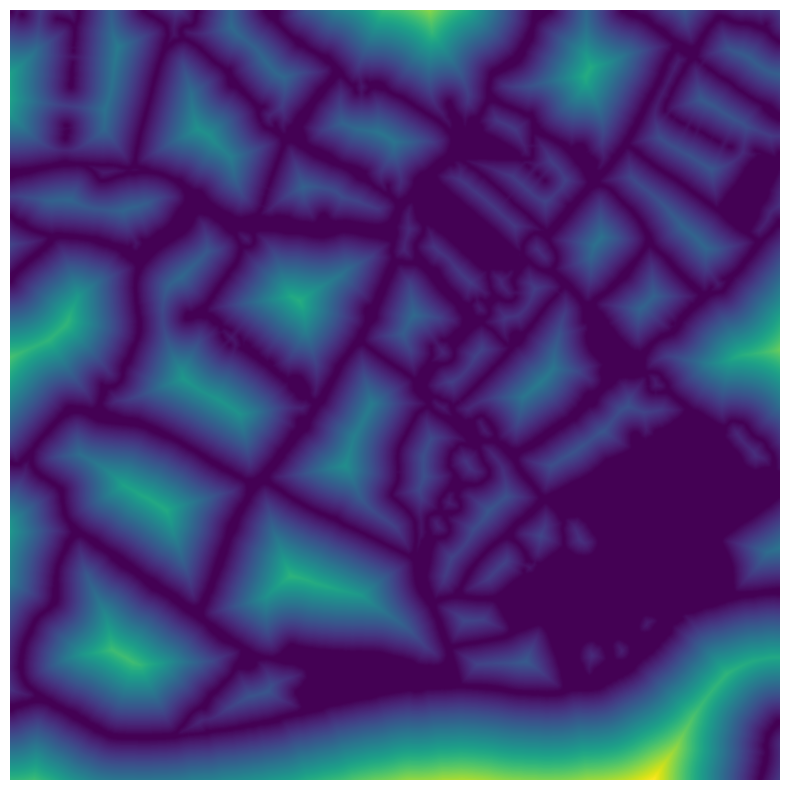

In [19]:
r_dst_mrg = ndistance(resulting_mask)
plt.figure(figsize=(10,10))
plt.imshow(r_dst_mrg)
plt.axis('off')

(-0.5, 1999.5, 1999.5, -0.5)

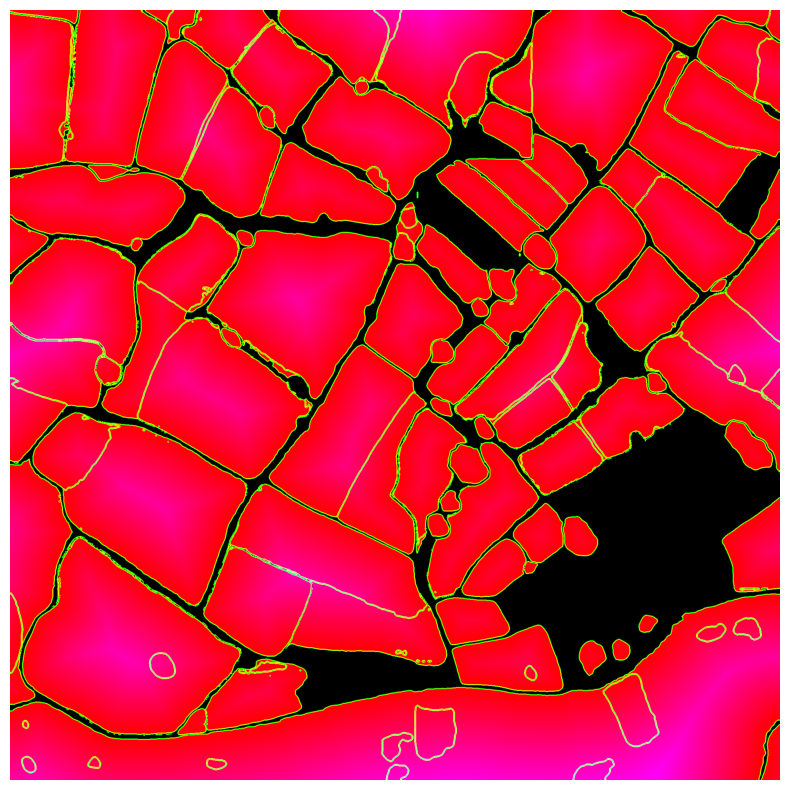

In [20]:
feature_mask = np.stack([r_xtt_mrg, r_bnd_mrg, r_dst_mrg],axis=2)
plt.figure(figsize=(10,10))
plt.imshow(feature_mask)
plt.axis('off')

In [21]:
with rasterio.open('out/output_grid_0_0_out.tif', 'w+', **meta) as out:
    out.write_band(1, r_xtt_mrg.astype(np.float32))
    out.write_band(2, r_bnd_mrg.astype(np.float32))
    out.write_band(3, r_dst_mrg.astype(np.float32))
out.close()

In [22]:
def InstSegm(extent: np.ndarray, boundary: np.ndarray, t_ext: float, t_bound: float) -> np.ndarray:
    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)
    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    # input_hws = boundary
    input_hws[ext_binary == 0] = 1
    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(graph, input_hws, hg.WeightFunction.mean)
    tree, altitudes = hg.watershed_hierarchy_by_dynamics(graph, edge_weights)
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(tree, altitudes, threshold=t_bound)
    # TODO: scale down instances and check if no zeros
    instances[ext_binary == 0] = 0
    # mask = instances.astype(np.uint8)
    # mask[ext_binary != 0] = 1
    return instances.astype(np.int32)


In [23]:
with rasterio.open('out/output_grid_0_0_out.tif') as src:
    img = src.read()
    meta = src.meta.copy()
# adjust metadata to allow tiff storage
meta['dtype'] = 'int32'
meta['count'] = 1

In [24]:
segmented_image = InstSegm(img[0], img[1], t_ext=1, t_bound=0.5)
out_filename = 'out/output_grid_0_0_higra.tif'
with rasterio.open(out_filename, mode='w', **meta) as dataset:
    dataset.write(segmented_image, 1)

(-0.5, 1999.5, 1999.5, -0.5)

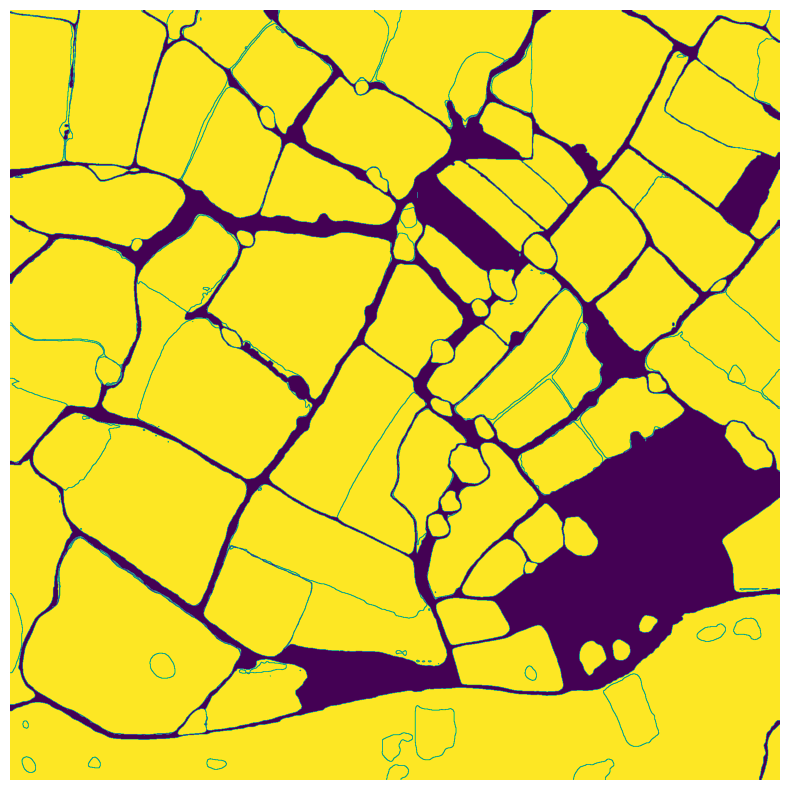

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(segmented_image)
plt.axis('off')

In [26]:
dataset.close()

In [1]:
import numpy as np
def build_point_grid(n_per_side: int) -> np.ndarray:
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * n_per_side)
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points

In [2]:
pts = build_point_grid(32)

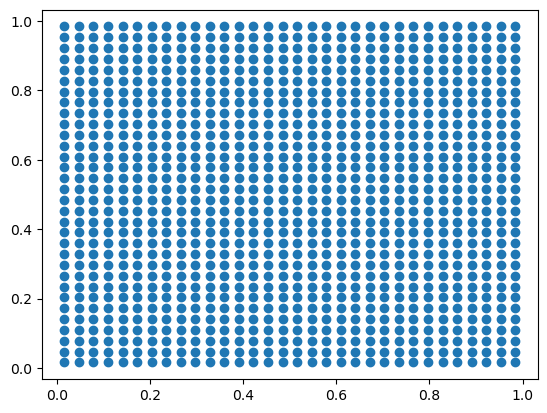

In [3]:
import matplotlib.pyplot as plt
plt.scatter(pts[:, 0], pts[:, 1])

